# Keywords generation
The goal is to use the abstract from papers we know reference ACDC to get the list of most present word and use this as keywords for other papers

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import requests
from sklearn.decomposition import PCA
from ast import literal_eval
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import math
import numpy as np

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
#Remove stopwords for easier parsing afterwards
stop_words = set(stopwords.words("english"))

datasets =["ACDC","I2CVB","BRATS","M&Ms"]
df = pd.read_csv("../../results/extracted_csv/paper_openalex.csv")

[nltk_data] Downloading package stopwords to /home/theo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Get for each dataset the count of papers with a word in their abstract

In [3]:
query_url = "https://api.openalex.org/works/doi"

counters = []
for d in datasets:
    word_count = Counter()
    df_dataset = df[df["dataset_used"] == d]
    for doi in df_dataset['DOI']:
        r = requests.get(query_url+doi)
        if r.status_code == 200:
            r_json = r.json()
            if r_json["abstract_inverted_index"]:
                for w in r_json["abstract_inverted_index"]:
                    w_clean = ''.join(filter(str.isalnum, w)).lower()
                    if w_clean not in stop_words:
                        word_count[w_clean] += 1
        else:
            print(f"Error {r.status_code} for {doi}")
            break
    counters.append(word_count)

Apply tf-idf to make discrimative word more important

In [4]:
tf_idf_counters = []
for i,dataset_count in enumerate(counters):
    tf_idf_c = Counter()
    N = sum([len(df[df["dataset_used"] == d]) for d in datasets])
    for w in dataset_count:
        tf_num = dataset_count[w]/len(df[df["dataset_used"] == datasets[i]])
        dfx = sum([dc[w] for dc in counters])
        tf_idf_c[w] =tf_num*math.log(N/dfx)
    tf_idf_counters.append(tf_idf_c)

In [35]:
for i,count in enumerate(counters):
    df_wc = pd.DataFrame.from_dict([count]).T
    df_wc = df_wc.sort_values(by=0,ascending=False)
    df_wc.to_csv(f"../../results/classification/wordcount_{datasets[i]}.csv")

for i,count in enumerate(tf_idf_counters):
    df_wc = pd.DataFrame.from_dict([count]).T
    df_wc = df_wc.sort_values(by=0,ascending=False)
    df_wc.to_csv(f"../../results/classification/wordcount_tfidf_{datasets[i]}.csv")

# Task Extraction
The goal is to classify the task of a paper using a list of keywords


In [36]:
with open("../../data/keywords.csv","r") as kw_file:
    keywords = next(kw_file)
    keywords = keywords.split(",")

## Keywords histogram extraction
Compute keywords histogram for papers from OpenAlex that references ACDC.


In [39]:
query_url = "https://api.openalex.org/works/doi"

df_acdc = df[df["dataset_used"] == "ACDC"]
with open('../../results/classification/keywordsHist_ACDC.csv',"w") as kw_hist:
    kw_hist.write(f'doi,hist\n')
    for doi in df_acdc['DOI']:
        r = requests.get(query_url+doi)
        if r.status_code == 200:
            r_json = r.json()
            if r_json["abstract_inverted_index"]:
                hist = [0 for w in keywords]
                for i,word in enumerate(keywords):
                    clean_abstract = {''.join(filter(str.isalnum, w)).lower():r_json["abstract_inverted_index"][w] for w in r_json["abstract_inverted_index"]}
                    if word in clean_abstract:
                        hist[i] = len(clean_abstract[word])
                kw_hist.write(f'{doi},"{hist}"\n')

        else:
            print(f"Error {r.status_code} for {doi}")
            break


Compute keywords histogram for papers from OpenAlex with an abstract and which are tag with "Machine Learning" and "Segmentation" concepts.

In [7]:
query_url = "https://api.openalex.org/works"
with open('../../results/classification/keywordsHist.csv',"w") as kw_hist:
    kw_hist.write(f'doi,year,hist\n')
    for year in range(2014,2024):
        print(year)
        next_page = True
        page_number = 1
        while next_page:
            query_param = {
                'page':page_number,
                'filter':f"concepts.id:C89600930,concepts.id:C154945302,has_abstract:true,publication_year:{year}"
            }
            r_year = requests.get(query_url,params=query_param)
            if r_year.status_code == 200:
                r_json = r_year.json()
                if not r_json["results"]:
                    next_page = False
                else:
                    for paper in r_json["results"]:
                        hist = [0 for w in keywords]
                        for i,word in enumerate(keywords):
                            clean_abstract = {''.join(filter(str.isalnum, w)).lower():paper["abstract_inverted_index"][w] for w in paper["abstract_inverted_index"]}
                            if word in clean_abstract:
                                hist[i] = len(clean_abstract[word])
                        kw_hist.write(f'{paper["doi"]},{year},"{hist}"\n')
                    page_number += 1
            else:
                next_page=False
            

2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


## Paper classification
Assign a task to a paper using its histogram of keywords using clustering

In [60]:
with open('../../results/classification/keywordsHist.csv','r') as f:
    df_hist = pd.read_csv(f)
    df_hist["hist"] = df_hist["hist"].apply(literal_eval)

hists = []
for d in df_hist["hist"].to_numpy():
    hists.append(d)
hist_norm = normalize(hists,axis=1)
pca = PCA(n_components=9)
hist_pca = pca.fit_transform(hist_norm)
print(sum(pca.explained_variance_ratio_))


kmeans = KMeans(n_clusters=2)
hist_cluster = kmeans.fit_predict(hist_pca)

df_hist["cluster"] = hist_cluster
df_hist.to_csv('../../results/classification/clusterisation_hist.csv')

0.7782110727415195


/home/theo/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [64]:
print(len(df_hist[df_hist['cluster'] == 1]))
df_hist[df_hist['cluster'] == 1]

456


,doi,year,hist,cluster
145,https://doi.org/10.1109/isbi.2014.6867948,2014,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
178,https://doi.org/10.1007/978-3-319-09994-1_22,2014,"[3, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
188,https://doi.org/10.4038/icter.v6i2.7150,2014,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
236,None,2014,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
294,https://doi.org/10.1109/isbi.2014.6868013,2014,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...
19668,https://doi.org/10.36828/szxf7275,2023,"[1, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1
19684,https://doi.org/10.21203/rs.3.rs-2590069/v1,2023,"[3, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, ...",1
19716,https://doi.org/10.1002/mp.16338,2023,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
19735,https://doi.org/10.1117/12.2669932,2023,"[4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1


### Using KDE

In [87]:
with open('../../results/classification/keywordsHist_ACDC.csv','r') as f:
    df_hist = pd.read_csv(f)
    #df_hist = df_hist[df_hist["hist"] != "[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"]
    df_hist["hist"] = df_hist["hist"].apply(literal_eval)
data = []
for d in df_hist["hist"].to_numpy():
    data.append(d)
data = np.array(data)


data_norm = normalize(data,axis=1)

X_train, X_test = train_test_split(data_norm, test_size=0.1, random_state=1907)
    
kde = KernelDensity(kernel='gaussian', bandwidth="silverman")
kde.fit(X_train)

test_x1 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
test_x2 = np.array([1, 1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
test_x = normalize([test_x1,test_x2],axis=1)

kde.score_samples(test_x)


array([-35.65458457, -36.03252364])

In [2]:
with open('../../results/classification/keywordsHist_ACDC.csv','r') as f:
    df_hist = pd.read_csv(f)
    df_hist["hist"] = df_hist["hist"].apply(literal_eval)
data = []
for d in df_hist["hist"].to_numpy():
    data.append(d)
data = np.array(data)

df = pd.DataFrame(data)
describe = df.mean().sort_values(ascending=False)

print(len(df))
for column_name in df.columns:
    column = df[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', count)

554
Count of zeros in column  0  is :  215
Count of zeros in column  1  is :  472
Count of zeros in column  2  is :  473
Count of zeros in column  3  is :  445
Count of zeros in column  4  is :  449
Count of zeros in column  5  is :  450
Count of zeros in column  6  is :  459
Count of zeros in column  7  is :  458
Count of zeros in column  8  is :  472
Count of zeros in column  9  is :  478
Count of zeros in column  10  is :  514
Count of zeros in column  11  is :  522
Count of zeros in column  12  is :  523
Count of zeros in column  13  is :  538
Count of zeros in column  14  is :  527
Count of zeros in column  15  is :  540
Count of zeros in column  16  is :  537
Count of zeros in column  17  is :  541
Count of zeros in column  18  is :  536
Count of zeros in column  19  is :  532
Count of zeros in column  20  is :  537
Count of zeros in column  21  is :  538
Count of zeros in column  22  is :  543
Count of zeros in column  23  is :  541
Count of zeros in column  24  is :  544
Count 

Text(0.5, 0, 'Year')

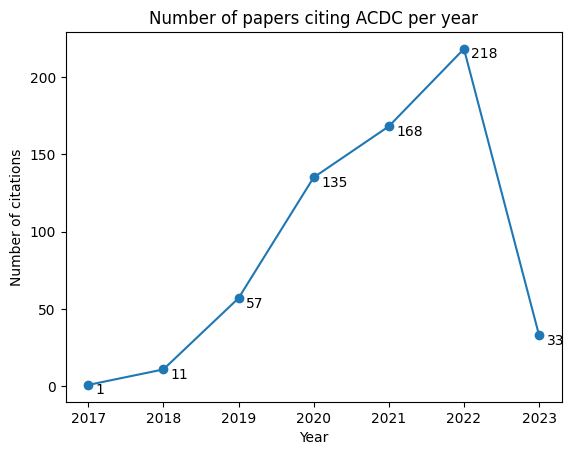

In [36]:
plt.figure()
ax = df_acdc.groupby(["publication_year"]).count()["dataset_used"].plot(style='-o')
for y in df_acdc.groupby(["publication_year"]).count().iterrows(): 
    ax.annotate(y[1][0],(y[0]+0.1, y[1][0]-6))
plt.title("Number of papers citing ACDC per year")
plt.ylabel("Number of citations")
plt.xlabel("Year")
plt